In [1]:
! pip install wandb ml_collections pytorch_fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.1 MB/s eta 0:00:00
  Created wheel for ml_collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=52679c9f8927d8c5befb0c31316d5d41719990c19deb474b71dc586729ccbd7d
  Stored in directory: /root/.cache/pip/wheels/fd/c2/0d/5d94d95e5875ea17b85a9f1f99b8dd2e50517137c8042c6468
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=ffda9c4b9a904cf5774cd9dd2fe364dfbd6ee0b63984951e078cf18

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('./drive/MyDrive/ddpm_hw_clean')

In [4]:
import torch
import numpy as np

from skimage.io import imread, imsave
from tqdm.auto import trange, tqdm
from torchvision.datasets import MNIST
from pytorch_fid import fid_score

from data_generator import DataGenerator
from default_mnist_config import create_default_mnist_config
from diffusion import DiffusionRunner
from models.classifier import ResNet, ResidualBlock, ConditionalResNet

from matplotlib import pyplot as plt

import os

#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from torchvision.transforms import Compose, Resize


#### Определим папку с настоящими картинками

In [5]:
def create_dir(path: str):
    if not os.path.exists(path):
        os.makedirs(path)

In [7]:
create_dir('../real_images_MNIST')

real_dataset = MNIST(root='../data', download=True, train=True, transform=Compose([Resize((32, 32))]))
for idx, (image_mnist, label) in enumerate(tqdm(real_dataset, total=len(real_dataset))):
    image = np.array(image_mnist)
    imsave("../real_images_MNIST/{}.png".format(idx), image)

  0%|          | 0/60000 [00:00<?, ?it/s]

### **Upd: Создадим папку с 10К настоящих картинок (для экономии времени).**

In [10]:
device = torch.device('cuda')

In [11]:
create_dir('../real_images_MNIST_10k')

TOTAL_IMAGES_COUNT = 10_000

real_dataset = MNIST(root='../data', download=True, train=True, transform=Compose([Resize((32, 32))]))
for idx, (image_mnist, label) in enumerate(tqdm(real_dataset, total=TOTAL_IMAGES_COUNT)):
    if idx == TOTAL_IMAGES_COUNT:
        break
    image = np.array(image_mnist)
    imsave("../real_images_MNIST_10k/{}.png".format(idx), image)


  0%|          | 0/10000 [00:00<?, ?it/s]

#### Определим папку для синтетических картинок и сгенерируем 60к картинок

### **Upd: сгенерируем 10К картинок для экономии времени, этого будет достаточно**

In [12]:
uncond_diff = DiffusionRunner(create_default_mnist_config(), eval=True)

In [13]:
create_dir('../uncond_mnist_10k')

TOTAL_IMAGES_COUNT = 10_000
BATCH_SIZE = 200
NUM_ITERS = TOTAL_IMAGES_COUNT // BATCH_SIZE

global_idx = 0
for idx in trange(NUM_ITERS):
    images: torch.Tensor = uncond_diff.sample_images(batch_size=BATCH_SIZE).cpu()
    images = images.permute(0, 2, 3, 1).data.numpy().astype(np.uint8)

    for i in range(len(images)):
        imsave(os.path.join('../uncond_mnist_10k', f'{global_idx}.png'), images[i])
        global_idx += 1

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-13-149947a87f8a>:13: UserWarning: ../uncond_mnist_10k/151.png is a low contrast image
  imsave(os.path.join('../uncond_mnist_10k', f'{global_idx}.png'), images[i])
<ipython-input-13-149947a87f8a>:13: UserWarning: ../uncond_mnist_10k/573.png is a low contrast image
  imsave(os.path.join('../uncond_mnist_10k', f'{global_idx}.png'), images[i])
<ipython-input-13-149947a87f8a>:13: UserWarning: ../uncond_mnist_10k/777.png is a low contrast image
  imsave(os.path.join('../uncond_mnist_10k', f'{global_idx}.png'), images[i])
<ipython-input-13-149947a87f8a>:13: UserWarning: ../uncond_mnist_10k/1102.png is a low contrast image
  imsave(os.path.join('../uncond_mnist_10k', f'{global_idx}.png'), images[i])
<ipython-input-13-149947a87f8a>:13: UserWarning: ../uncond_mnist_10k/1290.png is a low contrast image
  imsave(os.path.join('../uncond_mnist_10k', f'{global_idx}.png'), images[i])
<ipython-input-13-149947a87f8a>:13: UserWarning: ../uncond_mnist_10k/1860.png is a low contrast image
 

In [15]:
fid_value = fid_score.calculate_fid_given_paths(
    paths=['../real_images_MNIST_10k', '../uncond_mnist_10k'],
    batch_size=200,
    device=device,
    dims=2048
)
fid_value

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 183MB/s]
100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


120.00414579696934

> Какой фид получился? Сравните FID для безусловной генерации и для условной. Сгенерируйте для каждого класса по 6к картинок и посчитайте FID между реальными и условно сгенерированными картинками.

FID получился равным 120.00414579696934 для безусловной генерации. Рассмотрим примеры результатов генерации для наглядности.

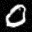

In [3]:
from PIL import Image
img = Image.open("../uncond_mnist_10k/17.png")
img

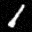

In [4]:
img = Image.open("../uncond_mnist_10k/228.png")
img

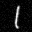

In [5]:
img = Image.open("../uncond_mnist_10k/9999.png")
img

В целом резултаты генерации кажутся достаточно качественными, однако было рассмотрено лишь несколько примеров.

Сравним далее с условной генерацией.

### Рассмотрим условную генерацию

In [17]:
cond_diff = DiffusionRunner(create_default_mnist_config(), eval=True)
cond_diff.model.eval()

classifier_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2]
}
noisy_classifier = ConditionalResNet(**classifier_args)
noisy_classifier.to(device)

noisy_classifier.load_state_dict(torch.load('./ddpm_checkpoints/classifier.pth'))

cond_diff.set_classifier(noisy_classifier, 1.0)


In [18]:
labels = torch.arange(10, device=device).repeat(BATCH_SIZE // 10)


In [20]:
create_dir('../cond_mnist_10k')


global_idx = 0
for idx in trange(NUM_ITERS):
    images: torch.Tensor = cond_diff.sample_images(batch_size=BATCH_SIZE, labels=labels).cpu()
    images = images.permute(0, 2, 3, 1).data.numpy().astype(np.uint8)

    for i in range(len(images)):
        imsave(os.path.join('../cond_mnist_10k', f'{global_idx}.png'), images[i])
        global_idx += 1

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-20-c842d3d8b9a9>:10: UserWarning: ./cond_mnist_10k/215.png is a low contrast image
  imsave(os.path.join('./cond_mnist_10k', f'{global_idx}.png'), images[i])
<ipython-input-20-c842d3d8b9a9>:10: UserWarning: ./cond_mnist_10k/407.png is a low contrast image
  imsave(os.path.join('./cond_mnist_10k', f'{global_idx}.png'), images[i])
<ipython-input-20-c842d3d8b9a9>:10: UserWarning: ./cond_mnist_10k/501.png is a low contrast image
  imsave(os.path.join('./cond_mnist_10k', f'{global_idx}.png'), images[i])
<ipython-input-20-c842d3d8b9a9>:10: UserWarning: ./cond_mnist_10k/691.png is a low contrast image
  imsave(os.path.join('./cond_mnist_10k', f'{global_idx}.png'), images[i])
<ipython-input-20-c842d3d8b9a9>:10: UserWarning: ./cond_mnist_10k/1420.png is a low contrast image
  imsave(os.path.join('./cond_mnist_10k', f'{global_idx}.png'), images[i])
<ipython-input-20-c842d3d8b9a9>:10: UserWarning: ./cond_mnist_10k/1445.png is a low contrast image
  imsave(os.path.join('./cond_mnist

In [22]:
fid_value = fid_score.calculate_fid_given_paths(
    paths=['../real_images_MNIST_10k', '../cond_mnist_10k'],
    batch_size=200,
    device=device,
    dims=2048
)
fid_value

100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


124.46283798125029

Получился FID равный 124.46283798125029, что больше, чем у безусловной генерации. Рассмотрим примеры результатов.

In [6]:
img = Image.open("../cond_mnist_10k/1337.png")
img

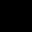

In [7]:
img = Image.open("../uncond_mnist_10k/777.png")
img

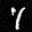

In [8]:
img = Image.open("../uncond_mnist_10k/2007.png")
img

На рассмотренных ихображениях встретились пустой результат генерации и некачественная цифра. Однако в качестве примеров было рассмотрено лишь несколько произвольных изображений, поэтому визуально сравнить с безусловной генерацией затруднительно.

Таким образом, FID для безусловной генерации получился немного меньше, чем для условной, и согласно определению и интерпретации данной метрики, это говорит о том, что для безусловной генерации результат ближе к распределению истинных картинок, чем для условной. С одной стороны это кажется нелогичным с учетом визульно немного лучших результатов в остальных экспериментах (в других ноутбуках в том числе), однако возможно так сказывается включение слагаемого скора от классификатора, несколько искажающего исходный скор (по сути отвечающий за приближение к истинному распределению) для безусловной генерации. Стоит также отметить, что модели обучались не все изначально предполагавшееся для них число итераций, поэтому при полноценном обучении результаты могли бы отличаться.
